In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from print_array import *
import time
import scipy.optimize as opt

In [8]:

class instrument:
    xmin=0; xmax=100; ymin=0; ymax=100 #boundaries for search
  
    def __init__(self,motorspeed,error,starttime):#s/steps,error for 1s integration time
        self.motorspeed=motorspeed
        self.error=error
        self.starttime=starttime
        self.t=0
        self.pos=np.array([self.xmin+np.random.uniform(0,self.xmax-self.xmin),self.ymin+np.random.uniform(0,self.ymax-self.ymin)])#random position
        self.x1=np.random.uniform(1,90)
        self.x2=np.random.uniform(1,90)
        self.sig1=np.random.uniform(5.0,10.0)
        self.sig2=np.random.uniform(5.0,10.0)
        self.theta=np.random.uniform(0,2*np.pi)
        self.func=lambda x: np.exp(-0.5*((((x[0]-self.x1)*np.cos(self.theta)-(x[1]-self.x2)*np.sin(self.theta))/self.sig1)**2+(((x[0]-self.x1)*np.sin(self.theta)+(x[1]-self.x2)*np.cos(self.theta))/self.sig2)**2))
 
    def scan(self,x,st):#position, scan time
        self.t+=(abs(x[0]-self.pos[0])+abs(x[1]-self.pos[1]))*self.motorspeed+st+self.starttime
        self.pos=np.array(x)
        return self.func(x)+np.random.normal(0,self.error,(1))[0]*(0.1+0.9*st**-.5)
    

MIM_LP_DOAS=instrument(50,0.01,0.5)
print('measurement value at [20,30] for a integaration time of 10s:',MIM_LP_DOAS.scan([20,30],10))


measurement value at [20,30] for a integaration time of 10s: 0.11691012693498708


In [9]:
def calc_std(n, st):
    instr_std = instrument(1,.05,0)
    measure = np.zeros(n)
    for i in range(n):
        measure[i] = instr_std.scan([20,30], st)
    std = measure.std()
    return std

**Better Search Algorithm**

In [10]:
scantimes = np.arange(1,100,1)
stds = np.zeros(len(scantimes))
for i in scantimes:
    stds[i-1] = calc_std(100,i)
    
#fit the following function f(t) = c1 + c2/sqrt(t)

fit_func = lambda t, c1, c2 : c1 + c2 / np.sqrt(t)
opt_param, opt_cov = opt.curve_fit(fit_func, scantimes, stds)

In [76]:
def construct_coords(center, step):
    
    #working our way towards the maximum in two circles with 1*step and 2*step distance to the center:
    # inner circle: 8 points
    # outer circle: 16 points
    

        
    compare_coord = np.array(((0,1),\
                              (np.sqrt(0.5),np.sqrt(0.5)),\
                              (1,0),\
                              (np.sqrt(0.5),-np.sqrt(0.5)),\
                              (0,-1),\
                              (-np.sqrt(0.5),-np.sqrt(0.5)),\
                              (-1,0),\
                              (-np.sqrt(0.5),np.sqrt(0.5)),\
                              (0,2),\
                              (-1*np.sqrt(4/1.25)/2,2*np.sqrt(4/1.25)/2),\
                              (-2*np.sqrt(0.5),2*np.sqrt(0.5)),\
                              (-2*np.sqrt(4/1.25)/2,1*np.sqrt(4/1.25)/2),\
                              (-2,0),\
                              (-2*np.sqrt(4/1.25)/2,-1*np.sqrt(4/1.25)/2),\
                              (-2*np.sqrt(0.5),-2*np.sqrt(0.5)),\
                              (-1*np.sqrt(4/1.25)/2,-2*np.sqrt(4/1.25)/2),\
                              (0,-2),\
                              (1*np.sqrt(4/1.25)/2,-2*np.sqrt(4/1.25)/2),\
                              (2*np.sqrt(0.5),-2*np.sqrt(0.5)),\
                              (2*np.sqrt(4/1.25)/2,-1*np.sqrt(4/1.25)/2),\
                              (2,0),\
                              (2*np.sqrt(4/1.25)/2,1*np.sqrt(4/1.25)/2),\
                              (2*np.sqrt(0.5),2*np.sqrt(0.5)),\
                              (1*np.sqrt(4/1.25)/2,2*np.sqrt(4/1.25)/2)))

    
    coords = np.full((len(compare_coord)+1,2), center)
    
    coords[1:,:] = coords[1:,:] + compare_coord[:,:]*step
            
    return coords

In [112]:
def grid_search(scan_grid, xmin, xmax, nsteps):
    
    max_box = 0.0
    max_box_i = 0
    step = int((xmax-xmin)/nsteps)
    
    for i in np.arange(xmin, xmax, step):
        i = int(i) + 1
        for j in np.arange(xmin, xmax, step):
            j = int(j) + 1
            if(np.mean(scan_grid[xmax - i - step:xmax - i, xmax - j - step:xmax - j]) > max_box): 
                max_box = np.mean(scan_grid[xmax - i - step:xmax - i, xmax - j - step:xmax - j])
                max_box_i = [xmax - i - int(step/2), xmax - j - int(step/2)]
    
    return max_box_i

Maximum of 1.0297715548592772 found at: (90, 70)


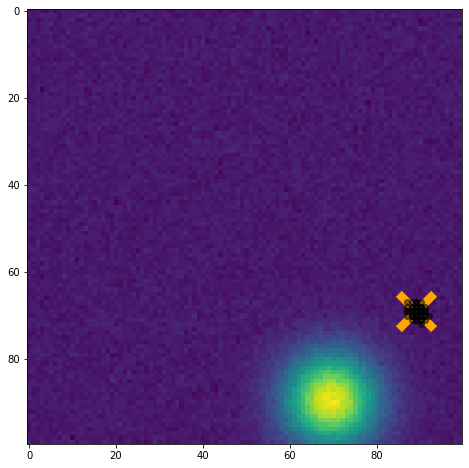

In [121]:
instr_search = instrument(1,.05,0)

xmax = instr_search.xmax
ymax = instr_search.ymax
xmin = instr_search.xmin
ymin = instr_search.ymin

acc = 1.0
scantime = 10

n_x = (xmax-xmin)/acc
n_y = (ymax-ymin)/acc

scan_grid = np.zeros((int(n_x),int(n_y)))

for i in np.arange(n_x): 
    for j in np.arange(n_y):
        scan_grid[int(i),int(j)] = instr_search.scan([int(xmin+acc*i),int(ymin+acc*j)], scantime)
        
plt.figure(figsize = (8,8))
plt.imshow(scan_grid)


step_initial = xmax / 100
step = step_initial
center_initial = grid_search(scan_grid, xmin, xmax, 5)

plt.scatter(center_initial[0],center_initial[1], color = 'orange', marker = 'x', linewidth = 50)

center = center_initial
scantime = 500

maximum = 0.0
new_maximum = 0.0
coord_max = center

search = True

while(search == True):
    
    coords = construct_coords(center, step)
    
    for i in coords:
        
        plt.scatter(i[0],i[1], color = 'k', alpha = 0.5)
        if(scan_grid[int(i[0]),int(i[1])] - new_maximum >= 3*fit_func(scantime, opt_param[0], opt_param[1])):
            new_maximum = scan_grid[int(i[0]),int(i[1])]
            coord_max = int(i[0]),int(i[1])
    
    #plt.scatter(coord_max[0],coord_max[1], color = 'k')
    
    if(new_maximum - maximum < 3*fit_func(scantime, opt_param[0], opt_param[1])): 
        search = False
        
    maximum = new_maximum
    center = coord_max

print('Maximum of ' + str(maximum) + ' found at: ' + str(coord_max))
plt.show()

**Additional Stuff**

In [ ]:
scantimes = np.arange(1,100,1)
stds = np.zeros(len(scantimes))
for i in scantimes:
    stds[i-1] = calc_std(100,i)
    
#fit the following function f(t) = c1 + c2/sqrt(t)

fit_func = lambda t, c1, c2 : c1 + c2 / np.sqrt(t)
opt_param, opt_cov = opt.curve_fit(fit_func, scantimes, stds)

plt.figure(figsize=(8,8))
plt.plot(scantimes, stds, label = 'standard deviation')
plt.plot(scantimes, fit_func(scantimes, opt_param[0], opt_param[1]), label = 'fitted curve') 
plt.ylabel('standard deviation')
plt.xlabel('scantime in secs')
plt.show()

print('C1 = ' + str(opt_param[0]) + '\tC2 = ' + str(opt_param[1]))

In [ ]:
instr = instrument(50,0.01,0.5)

acc = 1.0
scantime = np.arange(0.01,1,99) 
stepsize = np.arange(1,10,1)

show = True

nx = (instr.xmax-instr.xmin)/acc
ny = (instr.ymax-instr.ymin)/acc

func_grid = np.zeros((int(nx),int(ny)))

for i in np.arange(nx): 
    for j in np.arange(ny):
        func_grid[int(i),int(j)] = instr.scan([int(instr.xmin+acc*i),int(instr.ymin+acc*j)], scantime)

fig, axs = plt.subplots(1,1,figsize=(12,12))
 
searchtime = 100
    
for k in scantime:
    for l in stepsize:
        t0 = time.time()

        maxxpos = int(instr.xmin);
        maxypos = int(instr.ymin);

        err = 0.05

        for i in np.arange(instr.xmin,instr.xmax,acc):
            for j in np.arange(instr.ymin,instr.ymax,acc):
                if (func_grid[int(i),int(j)]>func_grid[maxxpos,maxypos]):
                    maxxpos=int(i);
                    maxypos=int(j);
                    maxval = func_grid[maxxpos,maxypos];
                    if show:
                        plt.scatter(maxxpos,maxypos,color='black')

        t1 = time.time()
        
        if(t1-t0 < searchtime): 
            searchtime = t1-t0
            best_scantime = k
            best_stepsize = l

print('time needed for search: ' + str(searchtime))
print('maximum of' + str(maxval) + 'found at' + 'maxxpos\t' + 'maxypos')
print('best scantime: ' + str(scantime) + '\tbest stepsize: ' + str(best_stepsize))

if show:
    plt.imshow(func_grid.T[::-1,:], interpolation = 'nearest',cmap='jet_r', extent=[instr.xmin,instr.xmax,instr.ymin,instr.ymax])
    plt.show()
